In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment

%matplotlib inline

In [2]:
#Define some ad-hoc merging, splitting and mixing functions


def batch_split(batch, n_squares_side, n_channels=1):
    
    side = int(np.sqrt(batch.shape[1]))
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    print(np.sqrt(batch.shape[2]/n_channels))
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    return side, side_square

def resize_batch(batch, side_new):
    batch_new = np.zeros((batch.shape[0], side_new **2))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        a = imresize(np.reshape(batch[i,:], [side,side]), [side_new, side_new])
        a = a.flatten()
        a = a/255.0
        batch_new[i,:] = a.flatten()
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


In [3]:
#Define model params
batch_size = 100
n_iter = 5000
samples_per_num = 10
n_iter_sinkhorn = 20
noise_factor = 1.0
keep_prob =1.0
opt = 'sgd'
n_units = 256
temp = 1.0
lr = 0.1

#mnist data
rfield_size = 5
n_squares_side = 3
n_channels = 1
stride = 2
n_squares = n_squares_side **2

side, side_square = resized_dims(n_squares_side)


In [4]:
#Main neural network definitions

def create_log_alpha():
    #create the matrix of log_alpha, that will later will converted into a soft permutation
    #this relies on some NN processing (convolutional), see below
    fc = tf.contrib.layers.fully_connected
    flatten = tf.contrib.layers.flatten
    dropout = tf.contrib.layers.dropout
    def conv(input_image, kernel_shape, bias_shape):
        weights = tf.get_variable("weights", kernel_shape,
                                 initializer = tf.random_normal_initializer())
        biases = tf.get_variable("biases", bias_shape, 
                                initializer=tf.constant_initializer(0.0))
        convolutional = tf.nn.conv2d(input_image, weights, 
                                     strides = [1, 1, 1, 1],
                                     padding="SAME")
        out_relu = tf.nn.relu(convolutional + biases)
        out_maxpool =tf.nn.max_pool(out_relu, 
                                    ksize=[1, stride, stride, 1],
                                   strides=[1, stride, stride, 1],
                                   padding="SAME")
        return out_maxpool
    def conv_and_fc(input_image):
        with tf.variable_scope("conv1"):
            conv_output = conv(input_image, [rfield_size, rfield_size, n_channels, n_units], [n_units])
        fully_connected_output = dropout(tf.cast(fc(flatten(conv_output), n_squares, activation_fn = None), tf.float32),
                                        keep_prob)
        return fully_connected_output
    
    with tf.variable_scope("model_params"):
        log_alpha = tf.reshape(conv_and_fc(stack_scrambled_images_split), [-1, n_squares, n_squares])
    return log_alpha

In [5]:
#Now we define the main TF variables

scrambled_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, 1])
scrambled_split_tiled = tf.tile(scrambled_split, [samples_per_num, 1, 1, 1, 1])

stack_scrambled_images_split = tf.placeholder(tf.float32,[None, side_square, side_square, 1])

real_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, 1])
real_split_tiled = tf.tile(real_split, [samples_per_num, 1, 1, 1, 1])


temperature = tf.constant(temp, dtype=tf.float32)
global_step = tf.Variable(0, trainable=False)
fc = tf.contrib.layers.fully_connected



log_alpha = create_log_alpha()
(soft_perms_inf, log_alpha_w_noise) = sinkhorn_ops.gumbel_sinkhorn(log_alpha, temp, samples_per_num,
                                                                   noise_factor, n_iter_sinkhorn, squeeze=False)

inv_soft_perms = tf.transpose(soft_perms_inf, [0, 1, 3, 2])
inv_soft_perms_flat = tf.reshape( tf.transpose(inv_soft_perms, [1, 0, 2, 3]), [-1, n_squares, n_squares])

real_split_tiled = tf.reshape(real_split_tiled, [-1, n_squares, side_square ** 2 * n_channels])
scrambled_split_tiled = tf.reshape(scrambled_split_tiled, [-1, n_squares, side_square ** 2* n_channels])
ordered_inf = tf.matmul(inv_soft_perms_flat, scrambled_split_tiled)
l2s_diff = tf.reduce_mean(tf.square(real_split_tiled - ordered_inf))
opt = optimizer.set_optimizer(opt, lr, opt_eps=1e-8)
train_op = tf.contrib.training.create_train_op(l2s_diff, opt, global_step=global_step)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [6]:
#Lets train the model
data_train = input_data.read_data_sets('/tmp/', one_hot=True).train 
data_test = input_data.read_data_sets('/tmp/', one_hot=True).test 

init_op=tf.initialize_all_variables()
sess=tf.InteractiveSession()
sess.run(init_op)

for i in range(n_iter):
    np_x,np_y=data_train.next_batch(batch_size)
    np_x = resize_batch(np_x, side)

    real_images_split = batch_split(np_x, n_squares_side)
    scrambled_images_split = np.zeros(real_images_split.shape)
    
    for j in range(batch_size):
        perm = np.random.permutation(n_squares)
        scrambled_images_split[j,:, :, :] = real_images_split[j, perm, :, :]
    stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)
    _,loss=sess.run([train_op,l2s_diff],{real_split:real_images_split,
                                         scrambled_split:scrambled_images_split,
                                        stack_scrambled_images_split:stacked_scrambled_images_split})
    
   
    if i % 50 == 1:
        print('Step %d, Loss: %0.7f' % (i,loss))


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.


/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Step 1, Loss: 0.0670319
Step 51, Loss: 0.0148525
Step 101, Loss: 0.0103549
Step 151, Loss: 0.0103420
Step 201, Loss: 0.0109100
Step 251, Loss: 0.0089638
Step 301, Loss: 0.0102689
Step 351, Loss: 0.0067159
Step 401, Loss: 0.0082168
Step 451, Loss: 0.0079941
Step 501, Loss: 0.0069474
Step 551, Loss: 0.0080404
Step 601, Loss: 0.0075709
Step 651, Loss: 0.0091671
Step 701, Loss: 0.0064019
Step 751, Loss: 0.0074511
Step 801, Loss: 0.0063575
Step 851, Loss: 0.0066268
Step 901, Loss: 0.0091130
Step 951, Loss: 0.0084763
Step 1001, Loss: 0.0091790
Step 1051, Loss: 0.0053952
Step 1101, Loss: 0.0067059
Step 1151, Loss: 0.0077653
Step 1201, Loss: 0.0060088
Step 1251, Loss: 0.0070193
Step 1301, Loss: 0.0066228
Step 1351, Loss: 0.0069580
Step 1401, Loss: 0.0058140
Step 1451, Loss: 0.0081549
Step 1501, Loss: 0.0077230
Step 1551, Loss: 0.0069600
Step 1601, Loss: 0.0067553
Step 1651, Loss: 0.0054583
Step 1701, Loss: 0.0059950
Step 1751, Loss: 0.0068416
Step 1801, Loss: 0.0069800
Step 1851, Loss: 0.00651

In [7]:
#Now let's test the model
batch_size_test=10
np_x,np_y=data_test.next_batch(batch_size_test)
np_x = resize_batch(np_x, side)
real_images_split = batch_split(np_x, n_squares_side)
scrambled_images_split = np.zeros(real_images_split.shape)
    
for i in range(batch_size_test):
    perm = np.random.permutation(n_squares)
    scrambled_images_split[i,:, :, :] = real_images_split[i, perm, :, :]
stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)
[unscrambled_images,loss, inv_soft_perms_np] = sess.run([ordered_inf,l2s_diff, inv_soft_perms],{real_split:real_images_split,
                            scrambled_split:scrambled_images_split,
                            stack_scrambled_images_split:stacked_scrambled_images_split})
unscrambled_images = unscrambled_images[:batch_size_test,:,:]
inv_hard_perms= np.zeros((batch_size_test, n_squares, n_squares))
for i in range(batch_size_test):
    inv_hard_perms[i,:,:] = soft_to_hard(inv_soft_perms_np[i,0,:,:])
unflatten_inf = unflatten_batch(unscrambled_images)
hard_inf = np.matmul(inv_hard_perms, np.reshape(scrambled_images_split, [batch_size_test,n_squares_side **2 ,-1]))
unflatten_hard_inf =np.reshape(hard_inf, unflatten_inf.shape)
joined_hard_inf =join_batch_split(unflatten_hard_inf)
joined_inf = join_batch_split(unflatten_inf)
joined_scrambled = join_batch_split(scrambled_images_split)
joined_real = join_batch_split(real_images_split)

9.0


/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


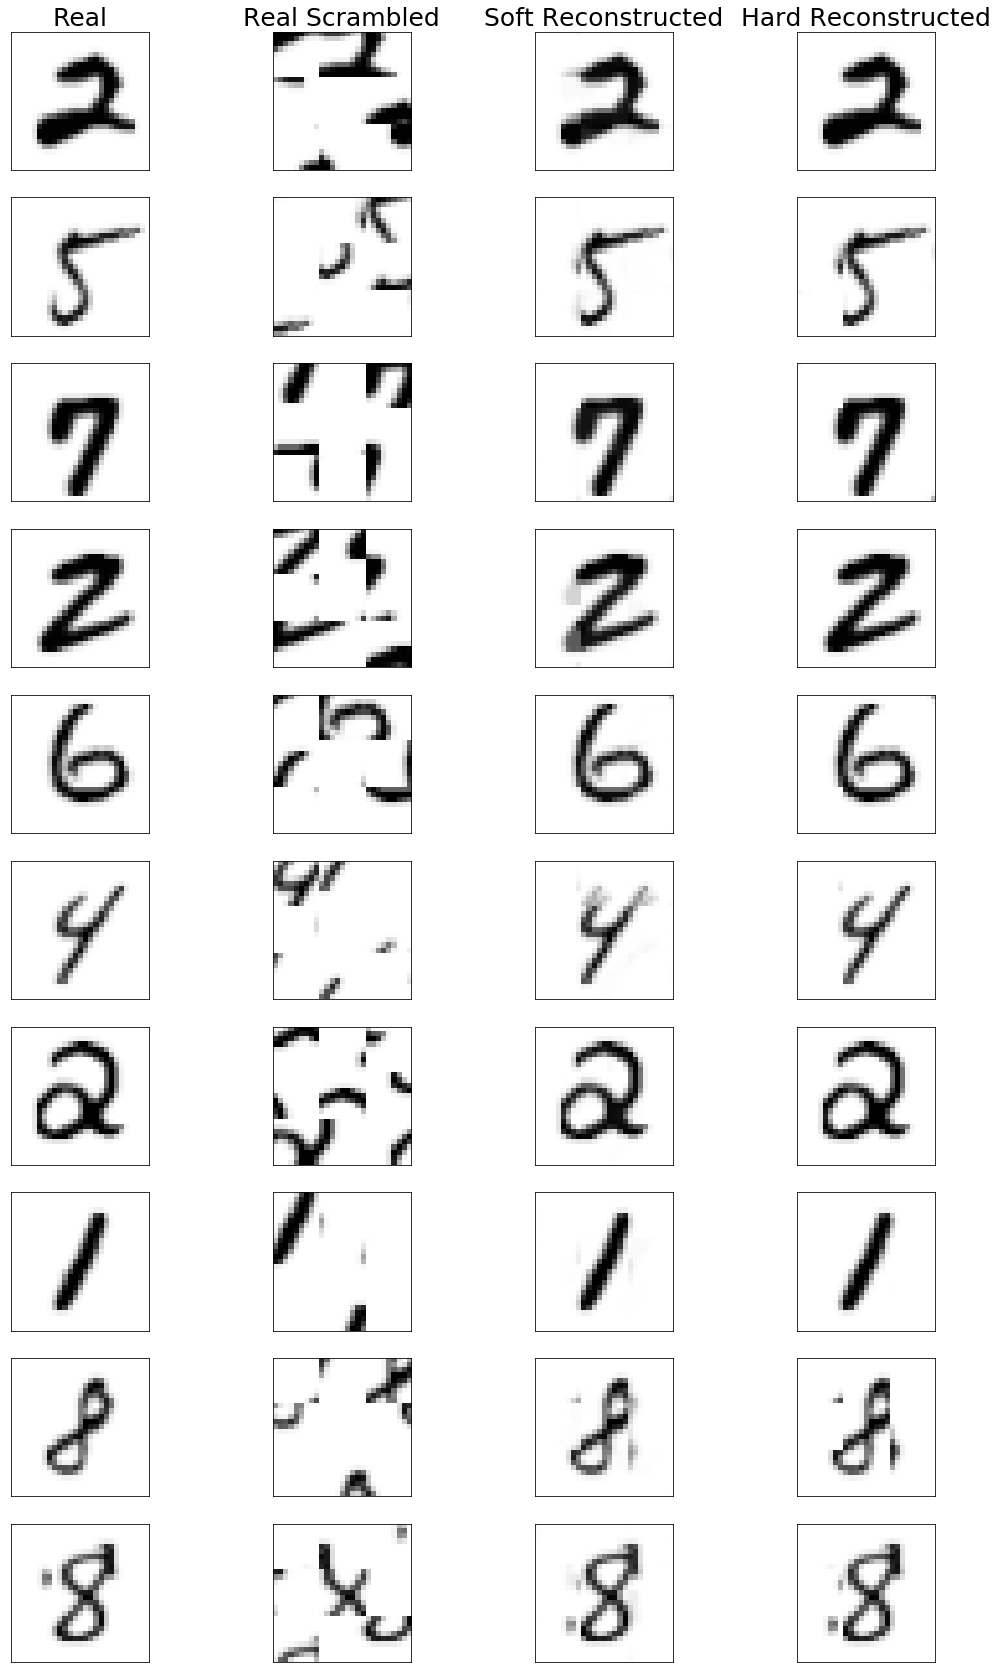

In [8]:
#Compare reconstructions with real data
fig, ax = plt.subplots(batch_size_test,4,figsize=(18,30))

for i in range(batch_size_test):
   
    ax[i,0].imshow(joined_real[i,:,:,0],cmap='Greys')
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    ax[i,1].imshow(joined_scrambled[i,:,:,0],cmap='Greys')
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
    
    ax[i,2].imshow(joined_inf[i,:,:,0],cmap='Greys')
    ax[i,2].get_xaxis().set_visible(False)
    ax[i,2].get_yaxis().set_visible(False)
    
    ax[i,2].imshow(joined_inf[i,:,:,0],cmap='Greys')
    ax[i,2].get_xaxis().set_visible(False)
    ax[i,2].get_yaxis().set_visible(False)
   
    ax[i,3].imshow(joined_hard_inf[i,:,:,0],cmap='Greys')
    ax[i,3].get_xaxis().set_visible(False)
    ax[i,3].get_yaxis().set_visible(False)
   

    if(i==0):
        ax[i,0].set_title('Real',fontsize =25)
        ax[i,1].set_title('Real Scrambled',fontsize =25)
        ax[i,2].set_title('Soft Reconstructed',fontsize =25)
        ax[i,3].set_title('Hard Reconstructed',fontsize =25)

In [9]:
scrambled_images_split.shape

(10, 9, 9, 9, 1)

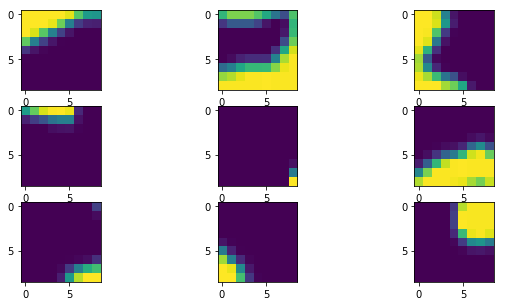

In [10]:
fix, ax =plt.subplots(3,3,figsize=(10,5))
ax=ax.flatten()
for i in range(9):
    ax[i].imshow(scrambled_images_split[0,i,:,:,0])

In [11]:
s=np.reshape(scrambled_images_split, [batch_size_test, n_squares, -1])

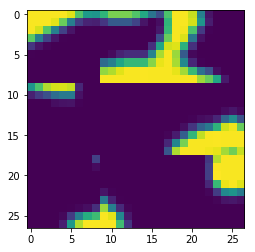

In [12]:
plt.imshow(joined_scrambled[0,:,:,0])

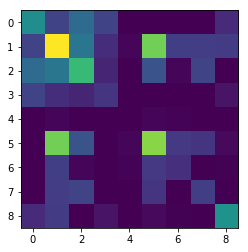

In [13]:
plt.imshow(np.matmul(s, np.transpose(s, [0,2,1]))[0,:,:])

In [14]:
def ma_A(n_squares):
    A=[]
    for k in range(n_squares):
        
        i = k % int(np.sqrt(n_squares))
        j = k / int(np.sqrt(n_squares))
        ii = []
        jj = []
        if(i>0):
            ii.append(i-1)
        if(i<np.sqrt(n_squares)-1):
            ii.append(i+1)
        if(j>0):
            jj.append(j-1)
        if(j<np.sqrt(n_squares)-1):
            jj.append(j+1)
        for iii in ii:
            a = np.zeros(n_squares)
            a[k] = 1
            kk = iii + int(np.sqrt(n_squares))*j
            
            a[kk] = -1
            A.append(a)
        for jjj in jj:
            a = np.zeros(n_squares)
            a[k] = 1
            kk = i + int(np.sqrt(n_squares))*jjj
            a[kk] = -1
            A.append(a)
    return np.array(A)

In [15]:
def ma_A_n(n):
    A=[]
    for k in range(n):
        kk=[]
        if(k>0):
            kk.append(k-1)
        if(k<n-1):
            kk.append(k+1)
        
        for kkk in kk:
            
            a = np.zeros(n)
            a[k] = 1
            a[kkk] =-1
            
            A.append(a)
    return np.array(A)

In [16]:
AA = np.matmul(ma_A(n_squares).T, ma_A(n_squares))
P = np.eye(n_squares)
XX = np.matmul(s, np.transpose(s, [0,2,1]))[0,:,:]
tau=0.5
for p in range(50):
    P=sinkhorn(np.matmul(AA, np.matmul(P, XX))/0.1)

NameError: name 'sinkhorn' is not defined

In [ ]:
AA = np.matmul(ma_A_n(n).T, ma_A_n(n))
P = 1*np.eye(n) 
P[0,1] = 0.9
P[0,0] = 0.1
P[1,1] = 0.1 
P[1,0] = 0.9
print(P)
P = sinkhorn(100*P + np.random.normal(0,1,[n,n]))
from copy import deepcopy
#perm = np.random.choice(n,n, replace=False)
s = np.sort(np.random.uniform(0,1, [n,1])*100, axis=0)
s2 
print(P)
XX = np.matmul(s, s.T)/100

eps=2
print(np.sum(P*np.matmul(AA, np.matmul(P, XX))))
tau=1.tau
logYt = P*0

for p in range(100):
    eps =eps*1
    tau=tau*1.0
    #logYt = logYt -tau*np.matmul(AA, np.matmul(P, XX)) -tau*eps*np.log(P)
    logYt = deepcopy(-tau*np.matmul(AA, np.matmul(P, XX))+(1-tau*eps )*np.log(P))

    #logYt = -tau*np.matmul(AA, np.matmul(P, XX))
    #logYt[np.isnan(logYt)] = 0
    
    P= deepcopy(sinkhorn(logYt, n_iters=5000))
    
    print(np.sum(P*np.matmul(AA, np.matmul(P, XX))))

print(np.sum(P,1))
print(s)
print(P)

print(np.sum(P*np.matmul(AA, np.matmul(P, XX))))
#print(np.matmul(AA, np.matmul(P0, XX)))
print(np.sum(np.diff(s,axis=0)**2)*2)/100


In [ ]:
n = 100
np.random.seed(10)


In [ ]:
P = 1*np.eye(n) 

print(P)
P = sinkhorn(100*P + np.random.normal(0,1,[n,n]))
from copy import deepcopy
#perm = np.random.choice(n,n, replace=False)
s = np.random.uniform(0,1, [n])
ds = (s[:,np.newaxis] - s[np.newaxis,:])**2
s2 = np.sort(s)
ds2 = (s2[:,np.newaxis] - s2[np.newaxis,:])**2
print(P)
print(ds2.shape)
print(ds.shape)
eps=0.5
tau=1./eps
logYt = P*0

for p in range(100):
    eps =eps*1.0
    tau=tau/1.0
    #logYt = deepcopy(tau*np.matmul(ds, np.matmul(P, ds2))+(1-tau*eps )*np.log(P))
    ab= np.matmul(ds, np.matmul(P, ds2))
    a2 = np.tile(np.nansum(ds **2, axis=1, keepdims=True), [1, n])
    b2 = np.tile(np.nansum(ds2 **2, axis=1, keepdims=True), [1, n]).T

    logYt = -tau* (a2+b2 - 2 *ab)
    
    P= deepcopy(sinkhorn(logYt, n_iters=50))
    a=np.sum((np.matmul(P.T,s)-s2)**2)
    b = np.sum((np.matmul(P.T,s)+np.sort(-s2))**2)
    print([a,b])

#print(np.matmul(AA, np.matmul(P0, XX)))
print(np.sum(np.diff(s,axis=0)**2)*2)/100


In [ ]:
print(s)
print(np.matmul(P,s))
print(np.matmul(P.T,s))

print(s2)
print(P)
plt.scatter(s2,np.matmul(P,s))
print(np.sum(np.matmul(P,s)-s2)**2)
print(np.matmul(P,s)-s2)
print(np.matmul(P,s))

In [ ]:
from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for _ in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
    return np.exp(log_alpha)

In [ ]:
batch_size_test=10
np_x,np_y=data_test.next_batch(batch_size_test)
np_x = resize_batch(np_x, side)
real_images_split = batch_split(np_x, n_squares_side)
scrambled_images_split = np.zeros(real_images_split.shape)
perms =[]    
Ps = np.zeros((batch_size_test, n_squares, n_squares))
for i in range(batch_size_test):
    perm = np.random.permutation(n_squares)
    perm = np.arange(n_squares)
    perm[0]=1
    perm[1]=0
    perm[7]=6
    perm[6]=7
    perm[4]=3
    perm[3]=4
    for k in range(n_squares):
        Ps[i,k,perm[k]] =1
    perms.append(perm)
    scrambled_images_split[i,:, :, :] = real_images_split[i, perm, :, :]
stacked_scrambled_images_split = stack_batch_split(scrambled_images_split)


In [ ]:
print(scrambled_images_split.shape)
ims = np.reshape(scrambled_images_split[0,:,:,:,0], [n_squares, -1])
#ims = np.reshape(real_images_split[0,:,:,:,0], [n_squares, -1])

im = np.reshape(real_images_split[0,:,:,:,0], [n_squares, -1])
sqim = np.tile(np.sum(im **2, axis=1, keepdims=True), [1, n_squares])

d = sqim +sqim.T - 2*np.matmul(im, im.T)
sqims= np.tile(np.sum(ims **2, axis=1, keepdims=True), [1, n_squares])
ds = sqims +sqims.T - 2*np.matmul(ims, ims.T)
eps=0.01
tau=1./eps
logYt = P*0
P = 1*np.eye(n_squares) 
#P = Ps[0]
print(perm)
print(np.sum((np.matmul(P,im)-ims)**2))
for p in range(100):
    eps =eps*1.0
    tau=tau/1.0
    #logYt = deepcopy(tau*np.matmul(ds, np.matmul(P, ds2))+(1-tau*eps )*np.log(P))
    ab= np.matmul(ds, np.matmul(P, d))
    a2 = np.tile(np.nansum(ds **2, axis=1, keepdims=True), [1, n_squares])
    b2 = np.tile(np.nansum(d **2, axis=1, keepdims=True), [1, n_squares]).T

    logYt = -tau* (a2+b2 - 2 *ab)
    
    P= deepcopy(sinkhorn(logYt, n_iters=500))
    a=np.sum((np.matmul(P,im)-ims)**2)
    b = np.sum((np.matmul(P,ims)-im)**2)
    print([a,b])
print(P)

In [ ]:
plt.imshow(P)

In [ ]:
plt.imshow(Ps[0])